In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
# ONLY TO RUN FOR GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

In [5]:
train_data_dir = 'FaceMaskDataset/Train'
validation_data_dir = 'FaceMaskDataset/Validation'

# GDRIVE SETUP
train_data_dir ='/content/drive/MyDrive/Colab Notebooks/Capstone 2/Project/FaceMaskDataset/Train'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 2/Project/FaceMaskDataset/Validation'
## 

IMG_SIZE = [224, 224]
INIT_LR = 1e-4 # 0.0001
EPOCHS = 30
BS = 64

train_datagen = ImageDataGenerator(rescale = 1./225,
                                  samplewise_center = True,
                                   samplewise_std_normalization = True,
                                  rotation_range = 10,    # No to test
                                  horizontal_flip = True)  # No to test

val_datagen = ImageDataGenerator(rescale = 1./225)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                        target_size = tuple(IMG_SIZE),
                                                        batch_size = 64,
                                                        shuffle = True,
                                                        class_mode = 'binary')
val_generator = val_datagen.flow_from_directory(directory = validation_data_dir,
                                                        target_size = tuple(IMG_SIZE),
                                                        batch_size = 64,
                                                        shuffle = False,
                                                        class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


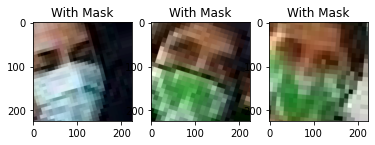

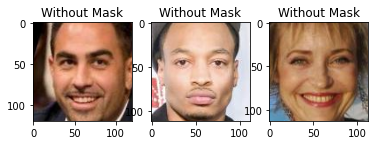

In [7]:
masked_images = os.listdir(train_data_dir +'/WithMask')
unmasked_images = os.listdir(train_data_dir + '/WithoutMask')

plt.figure(figsize = (6, 2))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_data_dir + "/WithMask",masked_images[i])))
    plt.title("With Mask")

plt.figure(figsize = (6, 2))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_data_dir + "/WithoutMask",unmasked_images[i])))
    plt.title("Without Mask")

In [32]:
mobilenet = MobileNetV2(input_shape = (224, 224, 3), include_top = False)
for layer in mobilenet.layers:
    layer.trainable = True
    
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [33]:
# Adding Base Layers to the Model

X = AveragePooling2D(pool_size=(7, 7))(mobilenet.output)
X = Flatten(name="flatten")(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
prediction = Dense(1, activation= 'sigmoid')(X)
model = Model(inputs = mobilenet.input, outputs = prediction)
# model.summary()

In [34]:
# MOdel Compilation

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
history = model.fit(train_generator,
                    epochs = 20,
                    validation_data= val_generator,
                    verbose = 1)

Epoch 1/20
157/157 [==============================] - 3083s 20s/step - loss: 0.0676 - accuracy: 0.9738 - val_loss: 0.8105 - val_accuracy: 0.7925
Epoch 2/20
157/157 [==============================] - 141s 899ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.5416 - val_accuracy: 0.8988
Epoch 3/20
157/157 [==============================] - 142s 902ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 1.1598 - val_accuracy: 0.8100
Epoch 4/20
157/157 [==============================] - 142s 901ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 1.5180 - val_accuracy: 0.7638
Epoch 5/20
157/157 [==============================] - 141s 898ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 1.4606 - val_accuracy: 0.7850
Epoch 6/20
157/157 [==============================] - 143s 909ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.6861 - val_accuracy: 0.8700
Epoch 7/20
157/157 [==============================] - 142s 908ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.5764 - 

In [36]:
model.save('trained_face_mask.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


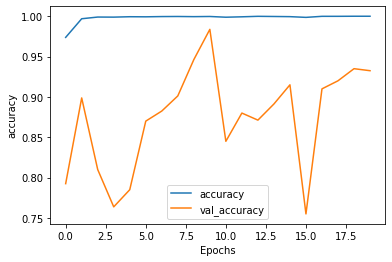

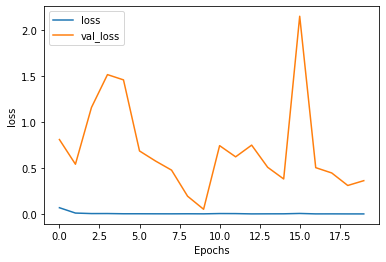

In [37]:
#  Assessing the Model Metrics

import matplotlib.pyplot as plt

def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [16]:
from tensorflow import keras
model_path = '/content/drive/MyDrive/Colab Notebooks/Capstone 2/Project/face_mask.h5'


model = keras.models.load_model(model_path)

In [18]:
# Evaluation on Test Data
test_datagen = ImageDataGenerator(rescale = 1./225,
                                  samplewise_center = True,
                                  samplewise_std_normalization = True)
                                      # No to test
                                   # No to test
test_dir = 'FaceMaskDataset/Test'
## Drive
test_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 2/Project/FaceMaskDataset/Test'
##
test_data = test_datagen.flow_from_directory(directory= test_dir,
                                                    target_size = tuple(IMG_SIZE),
                                                    shuffle = True,
                                                     class_mode = 'binary')
model.evaluate(test_data)

Found 992 images belonging to 2 classes.
31/31 [==============================] - 297s 10s/step - loss: 0.6388 - accuracy: 0.8236


[0.6387766003608704, 0.8235887289047241]

In [38]:
# Evaluation on Test Data for the custom trained mobilnet
test_datagen = ImageDataGenerator(rescale = 1./225,
                                  samplewise_center = True,
                                  samplewise_std_normalization = True)
                                      # No to test
                                   # No to test
test_dir = 'FaceMaskDataset/Test'
## Drive
test_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 2/Project/FaceMaskDataset/Test'
##
test_data = test_datagen.flow_from_directory(directory= test_dir,
                                                    target_size = tuple(IMG_SIZE),
                                                    shuffle = True,
                                                     class_mode = 'binary')
model.evaluate(test_data)

Found 992 images belonging to 2 classes.
31/31 [==============================] - 4s 120ms/step - loss: 0.0098 - accuracy: 0.9970


[0.009797363542020321, 0.9969757795333862]

[[1.]]


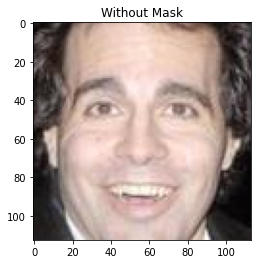

In [39]:
# Prediction on Model

pred_img_dir = 'FaceMaskDataset/Test/WithoutMask/1015.png'
pred_img_dir = test_dir + '/WithoutMask/1015.png'

image = tf.keras.preprocessing.image.load_img(path=pred_img_dir,
                                             target_size=tuple(IMG_SIZE))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
print(np.around(predictions))

# Image Display and Prediction
if np.around(predictions) == 1:
    plt.title('Without Mask')
else:
    plt.title("With Mask")
plt.imshow(plt.imread(pred_img_dir))

[[0.]]


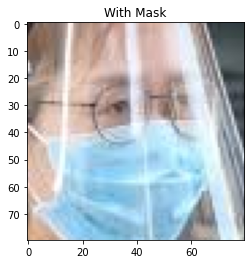

In [44]:
pred_img_dir = 'FaceMaskDataset/Test/WithMask/80.png'
pred_img_dir = test_dir + '/WithMask/742.png'
image = tf.keras.preprocessing.image.load_img(path=pred_img_dir,
                                             target_size=tuple(IMG_SIZE))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
print(np.around(predictions))

# Image Display and Prediction
if np.around(predictions) == 1:
    plt.title('Without Mask')
else:
    plt.title("With Mask")
plt.imshow(plt.imread(pred_img_dir))